In [ ]:
!pip install optuna -q
!pip install --upgrade datasets -q
!pip install --upgrade triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 12.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mounting drive where files are stored

Mounted at /content/drive


In [ ]:
import sys
path = "/content/drive/MyDrive/AI_Cybersecurity/Project/"
sys.path.append(path)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F # loading libraries
from sklearn.datasets import load_iris
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_from_disk
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from contextlib import nullcontext
from utils import BPE_Tokenizer, LSTM_model, train_model, test_model, run_inference_and_collect_results, calculate_auc_roc, plot_confusion_matrix, test_model_adversarial, run_inference_and_collect_results_adversarial, multiples_of_two

In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
tokenizer = BPE_Tokenizer(directory=path+'Tokenizer')
vocab = tokenizer.vocab
vocab_size = len(vocab) + 1
print("Vocab size is", vocab_size)

Vocab size is 10007


In [ ]:
tokenized_dataset = load_from_disk(path+"Datasets/FinalDataset/")

In [ ]:
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['validation']
test_dataset = tokenized_dataset['test']

In [ ]:
batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vector_length = 1024
hidden_length = 1024
num_layers = 2
dropout = 0.2
metadata_vector_length = 1024
num_metadata_features = len(train_dataset['metadata'][0])
num_epochs = 1
max_lr = 2e-4
scheduler_config = {"warmup_steps": 5,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": max_lr,
                    "min_lr": max_lr * 0.1}

In [ ]:
# Initialize the model for binary classification of class 0
model = LSTM_model(vocab_size, vector_length, hidden_length, num_layers, dropout, num_metadata_features, metadata_vector_length).to(device)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    logits, _ = model(inputs, attention_mask, metadata, labels)  # Forward pass through the model
    print(logits.shape)
    break

torch.cuda.empty_cache()

loss = test_model(model, train_loader, fp16=True, device="cuda")  # Compute the loss on the training dataset
print(f"Initial Training Loss {loss:.4f}")

torch.Size([128, 2])
Initial Training Loss 0.6999


In [ ]:
def objective(trial):
    # Define hyperparameters to optimize
    vector_length = trial.suggest_categorical("vector_length", multiples_of_two(128, 2048))
    hidden_length = trial.suggest_categorical("hidden_length", multiples_of_two(128, 2048))
    num_layers = trial.suggest_int("num_layers", 2, 5)
    num_epochs = trial.suggest_int("num_epochs", 1, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    metadata_vector_length = trial.suggest_categorical("metadata_vector_length", multiples_of_two(128, 2048))
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    warmup_steps = trial.suggest_int("warmup_steps", 10, 100, step=10)

    # Create the model
    model = LSTM_model(
        vocab_size=10240,
        vector_length=vector_length,
        hidden_length=hidden_length,
        num_layers=num_layers,
        dropout=dropout,
        padding_idx=tokenizer.padding_idx,
        num_metadata_features=num_metadata_features,
        metadata_vector_length=metadata_vector_length,
        num_classes=2
    ).to(device)
    model = torch.compile(model)

    # Optimizer
    optimizer = model.configure_optimizers(weight_decay=0.01, learning_rate=lr, device_type=device)

    scheduler_config = {"warmup_steps": warmup_steps,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": lr,
                    "min_lr": lr * 0.1}

    # Train the model
    model = train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        device=device,
        fp16=True,
        scheduler_config=scheduler_config,
        log_interval=10,
        early_stopping=True,
    )

    # Evaluate on the validation set
    val_loss = test_model(model, val_loader, device, fp16=True)

    # Return the validation loss as the objective to minimize
    return val_loss

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=50)

[I 2024-12-07 11:43:40,660] A new study created in memory with name: no-name-7753434d-ebb1-4927-9844-bd480664fed4


Num decayed parameter tensors: 20, with 25,220,352 parameters
Num non-decayed parameter tensors: 19, with 34,306 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7004, Average Validation Loss: 0.6991, Accuracy: 49.08%, Precision: 83.74%, Recall: 53.50%, F1: 0.65
Epoch 0, Average Training Loss: 0.6978, Average Validation Loss: 0.6977, Accuracy: 51.61%, Precision: 88.06%, Recall: 54.78%, F1: 0.68
Epoch 0, Average Training Loss: 0.6957, Average Validation Loss: 0.6954, Accuracy: 54.51%, Precision: 92.96%, Recall: 56.18%, F1: 0.70
Epoch 0, Average Training Loss: 0.6948, Average Validation Loss: 0.6923, Accuracy: 56.94%, Precision: 96.68%, Recall: 57.33%, F1: 0.72
Epoch 0, Average Training Loss: 0.6913, Average Validation Loss: 0.6888, Accuracy: 58.52%, Precision: 98.58%, Recall: 58.10%, F1: 0.73
Epoch 0, Average Training Loss: 0.6865, Average Validation Loss: 0.6852, Accuracy: 59.44%, Precision: 99.34%, Recall: 58.57%, F1: 0.74
Epoch 0, Average Training Loss: 0.6840, Av

[I 2024-12-07 12:19:50,441] Trial 0 finished with value: 0.04667895930643017 and parameters: {'vector_length': 256, 'hidden_length': 512, 'num_layers': 4, 'num_epochs': 3, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 1.4990412150722226e-06, 'warmup_steps': 40}. Best is trial 0 with value: 0.04667895930643017.


Num decayed parameter tensors: 24, with 454,148,608 parameters
Num non-decayed parameter tensors: 23, with 167,938 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5969, Average Validation Loss: 0.4158, Accuracy: 88.83%, Precision: 100.00%, Recall: 83.66%, F1: 0.91
Epoch 0, Average Training Loss: 0.2358, Average Validation Loss: 0.0910, Accuracy: 99.22%, Precision: 99.84%, Recall: 98.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0566, Average Validation Loss: 0.0416, Accuracy: 99.06%, Precision: 98.36%, Recall: 99.99%, F1: 0.99
Epoch 0, Average Training Loss: 0.0182, Average Validation Loss: 0.0130, Accuracy: 99.70%, Precision: 99.93%, Recall: 99.56%, F1: 1.00
Epoch 0, Average Training Loss: 0.0137, Average Validation Loss: 0.0060, Accuracy: 99.86%, Precision: 99.81%, Recall: 99.95%, F1: 1.00
Epoch 0, Average Training Loss: 0.0039, Average Validation Loss: 0.0017, Accuracy: 99.94%, Precision: 99.99%, Recall: 99.91%, F1: 1.00
Epoch 0, Average Training Loss: 0.0020,

[I 2024-12-07 12:33:21,911] Trial 1 finished with value: 0.0037234780329084526 and parameters: {'vector_length': 512, 'hidden_length': 2048, 'num_layers': 5, 'num_epochs': 4, 'dropout': 0.1, 'metadata_vector_length': 2048, 'lr': 0.0004044399051035035, 'warmup_steps': 60}. Best is trial 1 with value: 0.0037234780329084526.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4706, Average Validation Loss: 0.1496, Accuracy: 99.05%, Precision: 99.58%, Recall: 98.77%, F1: 0.99
Epoch 0, Average Training Loss: 0.0553, Average Validation Loss: 0.0075, Accuracy: 99.79%, Precision: 99.96%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0058, Average Validation Loss: 0.0043, Accuracy: 99.88%, Precision: 99.96%, Recall: 99.83%, F1: 1.00
Epoch 0, Average Training Loss: 0.0058, Average Validation Loss: 0.0070, Accuracy: 99.76%, Precision: 99.64%, Recall: 99.94%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0084, Average Validation Loss: 0.0019, Accuracy: 99.94%, Precision: 99.94%, Recall: 99.96%, F1: 1.00
Epoch 0, Average Training Loss: 0.0001, Average Validation Loss: 0.0109, Accuracy: 99.66%, Precision: 100.00%, Recal

[I 2024-12-07 12:35:56,277] Trial 2 finished with value: 0.0014212693657364563 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.0011800360164860848, 'warmup_steps': 50}. Best is trial 2 with value: 0.0014212693657364563.


Num decayed parameter tensors: 16, with 291,569,664 parameters
Num non-decayed parameter tensors: 15, with 101,378 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7126, Average Validation Loss: 0.7037, Accuracy: 33.58%, Precision: 55.96%, Recall: 43.70%, F1: 0.49
Epoch 0, Average Training Loss: 0.6874, Average Validation Loss: 0.6704, Accuracy: 57.72%, Precision: 99.78%, Recall: 57.51%, F1: 0.73
Epoch 0, Average Training Loss: 0.6498, Average Validation Loss: 0.6245, Accuracy: 58.68%, Precision: 99.94%, Recall: 58.06%, F1: 0.73
Epoch 0, Average Training Loss: 0.6043, Average Validation Loss: 0.5620, Accuracy: 67.77%, Precision: 99.96%, Recall: 63.96%, F1: 0.78
Epoch 0, Average Training Loss: 0.5234, Average Validation Loss: 0.4572, Accuracy: 84.42%, Precision: 99.96%, Recall: 78.61%, F1: 0.88
Epoch 0, Average Training Loss: 0.3691, Average Validation Loss: 0.3005, Accuracy: 87.99%, Precision: 99.02%, Recall: 83.19%, F1: 0.90
Epoch 0, Average Training Loss: 0.2448, 

[I 2024-12-07 12:51:36,921] Trial 3 finished with value: 0.020717553572880257 and parameters: {'vector_length': 2048, 'hidden_length': 2048, 'num_layers': 3, 'num_epochs': 4, 'dropout': 0.1, 'metadata_vector_length': 1024, 'lr': 2.3222107956914464e-05, 'warmup_steps': 90}. Best is trial 2 with value: 0.0014212693657364563.


Num decayed parameter tensors: 16, with 44,333,056 parameters
Num non-decayed parameter tensors: 15, with 25,602 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6903, Average Validation Loss: 0.6799, Accuracy: 60.64%, Precision: 99.44%, Recall: 59.30%, F1: 0.74
Epoch 0, Average Training Loss: 0.6630, Average Validation Loss: 0.6407, Accuracy: 60.08%, Precision: 99.98%, Recall: 58.89%, F1: 0.74
Epoch 0, Average Training Loss: 0.6190, Average Validation Loss: 0.5940, Accuracy: 60.60%, Precision: 99.99%, Recall: 59.21%, F1: 0.74
Epoch 0, Average Training Loss: 0.5782, Average Validation Loss: 0.5394, Accuracy: 70.38%, Precision: 99.99%, Recall: 65.89%, F1: 0.79
Epoch 0, Average Training Loss: 0.5038, Average Validation Loss: 0.4689, Accuracy: 79.08%, Precision: 99.99%, Recall: 73.22%, F1: 0.85
Epoch 0, Average Training Loss: 0.4366, Average Validation Loss: 0.3639, Accuracy: 87.87%, Precision: 99.99%, Recall: 82.51%, F1: 0.90
Epoch 0, Average Training Loss: 0.3254, Av

[I 2024-12-07 13:02:30,022] Trial 4 finished with value: 0.007644556783693465 and parameters: {'vector_length': 2048, 'hidden_length': 512, 'num_layers': 3, 'num_epochs': 4, 'dropout': 0.5, 'metadata_vector_length': 512, 'lr': 2.3747769895709317e-05, 'warmup_steps': 20}. Best is trial 2 with value: 0.0014212693657364563.


Num decayed parameter tensors: 16, with 3,893,248 parameters
Num non-decayed parameter tensors: 15, with 6,786 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7008, Average Validation Loss: 0.6959, Accuracy: 43.94%, Precision: 59.18%, Recall: 50.85%, F1: 0.55
Epoch 0, Average Training Loss: 0.6896, Average Validation Loss: 0.6802, Accuracy: 69.60%, Precision: 96.97%, Recall: 65.92%, F1: 0.78
Epoch 0, Average Training Loss: 0.6693, Average Validation Loss: 0.6550, Accuracy: 75.48%, Precision: 99.99%, Recall: 70.00%, F1: 0.82
Epoch 0, Average Training Loss: 0.6403, Average Validation Loss: 0.6196, Accuracy: 75.01%, Precision: 99.99%, Recall: 69.59%, F1: 0.82
Epoch 0, Average Training Loss: 0.6020, Average Validation Loss: 0.5718, Accuracy: 78.16%, Precision: 100.00%, Recall: 72.36%, F1: 0.84
Epoch 0, Average Training Loss: 0.5481, Average Validation Loss: 0.5118, Accuracy: 82.41%, Precision: 100.00%, Recall: 76.48%, F1: 0.87
Epoch 0, Average Training Loss: 0.4905, Av

[I 2024-12-07 13:08:05,205] Trial 5 finished with value: 0.012100986602741318 and parameters: {'vector_length': 256, 'hidden_length': 128, 'num_layers': 3, 'num_epochs': 2, 'dropout': 0.4, 'metadata_vector_length': 512, 'lr': 8.04256060676582e-05, 'warmup_steps': 50}. Best is trial 2 with value: 0.0014212693657364563.


Num decayed parameter tensors: 16, with 6,856,704 parameters
Num non-decayed parameter tensors: 15, with 12,674 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6941, Average Validation Loss: 0.6949, Accuracy: 42.78%, Precision: 19.30%, Recall: 49.94%, F1: 0.28
Epoch 0, Average Training Loss: 0.6944, Average Validation Loss: 0.6940, Accuracy: 44.15%, Precision: 26.72%, Recall: 52.29%, F1: 0.35
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.6934, Average Validation Loss: 0.6924, Accuracy: 49.29%, Precision: 41.04%, Recall: 58.01%, F1: 0.48
Epoch 0, Average Training Loss: 0.6922, Average Validation Loss: 0.6904, Accuracy: 58.43%, Precision: 62.04%, Recall: 64.11%, F1: 0.63
Epoch 0, Average Training Loss: 0.6890, Average Validation Loss: 0.6876, Accuracy: 67.34%, Precision: 87.36%, Recall: 66.26%, F1: 0.75
Epoch 0, Average Training Loss: 0.6865, Average Validation Loss: 0.6843, Accuracy: 67.57%, Precision: 97.49%, Recall:

[I 2024-12-07 13:24:23,192] Trial 6 finished with value: 0.03460305747953621 and parameters: {'vector_length': 256, 'hidden_length': 256, 'num_layers': 3, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 128, 'lr': 6.924720169742307e-06, 'warmup_steps': 60}. Best is trial 2 with value: 0.0014212693657364563.


Num decayed parameter tensors: 12, with 45,197,824 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6984, Average Validation Loss: 0.6761, Accuracy: 82.15%, Precision: 94.76%, Recall: 78.49%, F1: 0.86
Epoch 0, Average Training Loss: 0.6428, Average Validation Loss: 0.5946, Accuracy: 86.69%, Precision: 99.95%, Recall: 81.15%, F1: 0.90
Epoch 0, Average Training Loss: 0.5495, Average Validation Loss: 0.4842, Accuracy: 88.21%, Precision: 99.98%, Recall: 82.93%, F1: 0.91
Epoch 0, Average Training Loss: 0.4298, Average Validation Loss: 0.3659, Accuracy: 91.14%, Precision: 99.98%, Recall: 86.60%, F1: 0.93
Epoch 0, Average Training Loss: 0.3188, Average Validation Loss: 0.2461, Accuracy: 97.06%, Precision: 99.90%, Recall: 95.19%, F1: 0.97
Epoch 0, Average Training Loss: 0.2067, Average Validation Loss: 0.1549, Accuracy: 97.88%, Precision: 99.85%, Recall: 96.56%, F1: 0.98
Epoch 0, Average Training Loss: 0.1340, Av

[I 2024-12-07 13:31:26,610] Trial 7 finished with value: 0.005459543010471641 and parameters: {'vector_length': 512, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 5, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 3.838002400532093e-05, 'warmup_steps': 50}. Best is trial 2 with value: 0.0014212693657364563.


Num decayed parameter tensors: 12, with 38,119,552 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6441, Average Validation Loss: 0.5419, Accuracy: 96.76%, Precision: 99.84%, Recall: 94.78%, F1: 0.97
Epoch 0, Average Training Loss: 0.4165, Average Validation Loss: 0.2664, Accuracy: 96.34%, Precision: 99.95%, Recall: 94.02%, F1: 0.97
Epoch 0, Average Training Loss: 0.1729, Average Validation Loss: 0.0833, Accuracy: 99.30%, Precision: 99.50%, Recall: 99.28%, F1: 0.99
Epoch 0, Average Training Loss: 0.0510, Average Validation Loss: 0.0279, Accuracy: 99.58%, Precision: 99.60%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0175, Average Validation Loss: 0.0135, Accuracy: 99.73%, Precision: 99.67%, Recall: 99.85%, F1: 1.00
Epoch 0, Average Training Loss: 0.0177, Average Validation Loss: 0.0100, Accuracy: 99.71%, Precision: 99.89%, Recall: 99.61%, F1: 1.00
Epoch 0, Average Training Loss: 0.0066, Av

[I 2024-12-07 13:35:54,087] Trial 8 finished with value: 0.0013000633535714744 and parameters: {'vector_length': 128, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0003830264808479387, 'warmup_steps': 80}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 24, with 13,604,608 parameters
Num non-decayed parameter tensors: 23, with 12,418 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6484, Average Validation Loss: 0.5679, Accuracy: 97.18%, Precision: 99.80%, Recall: 95.47%, F1: 0.98
Epoch 0, Average Training Loss: 0.4606, Average Validation Loss: 0.3061, Accuracy: 98.43%, Precision: 99.67%, Recall: 97.64%, F1: 0.99
Epoch 0, Average Training Loss: 0.2002, Average Validation Loss: 0.0863, Accuracy: 99.27%, Precision: 99.62%, Recall: 99.11%, F1: 0.99
Epoch 0, Average Training Loss: 0.0450, Average Validation Loss: 0.0152, Accuracy: 99.68%, Precision: 99.93%, Recall: 99.51%, F1: 1.00
Epoch 0, Average Training Loss: 0.0067, Average Validation Loss: 0.0054, Accuracy: 99.83%, Precision: 99.94%, Recall: 99.77%, F1: 1.00
Epoch 0, Average Training Loss: 0.0080, Average Validation Loss: 0.0040, Accuracy: 99.87%, Precision: 99.97%, Recall: 99.81%, F1: 1.00
Epoch 0, Average Training Loss: 0.0049, Av

[I 2024-12-07 13:39:20,909] Trial 9 finished with value: 0.0019671808920778662 and parameters: {'vector_length': 1024, 'hidden_length': 128, 'num_layers': 5, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0010514686174328324, 'warmup_steps': 100}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 12, with 36,194,944 parameters
Num non-decayed parameter tensors: 11, with 34,050 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5467, Average Validation Loss: 0.3231, Accuracy: 85.97%, Precision: 99.93%, Recall: 80.33%, F1: 0.89
Epoch 0, Average Training Loss: 0.1462, Average Validation Loss: 0.0343, Accuracy: 99.26%, Precision: 98.84%, Recall: 99.87%, F1: 0.99
Epoch 0, Average Training Loss: 0.0298, Average Validation Loss: 0.0139, Accuracy: 99.47%, Precision: 99.15%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0072, Average Validation Loss: 0.0046, Accuracy: 99.89%, Precision: 99.93%, Recall: 99.87%, F1: 1.00
Epoch 0, Average Training Loss: 0.0003, Average Validation Loss: 0.0060, Accuracy: 99.89%, Precision: 99.99%, Recall: 99.82%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0305, Average Validation Loss: 0.0120, Accuracy: 99.74%, Precision: 99.93%, Recall

[I 2024-12-07 13:41:31,091] Trial 10 finished with value: 0.015361738761139105 and parameters: {'vector_length': 128, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 256, 'lr': 0.005129023395331515, 'warmup_steps': 80}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 12, with 38,119,552 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6326, Average Validation Loss: 0.4914, Accuracy: 95.74%, Precision: 99.91%, Recall: 93.14%, F1: 0.96
Epoch 0, Average Training Loss: 0.3494, Average Validation Loss: 0.1751, Accuracy: 98.32%, Precision: 99.82%, Recall: 97.31%, F1: 0.99
Epoch 0, Average Training Loss: 0.1073, Average Validation Loss: 0.0412, Accuracy: 99.28%, Precision: 99.78%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0272, Average Validation Loss: 0.0223, Accuracy: 99.45%, Precision: 99.09%, Recall: 99.95%, F1: 1.00
Epoch 0, Average Training Loss: 0.0157, Average Validation Loss: 0.0093, Accuracy: 99.77%, Precision: 99.77%, Recall: 99.83%, F1: 1.00
Epoch 0, Average Training Loss: 0.0063, Average Validation Loss: 0.0054, Accuracy: 99.88%, Precision: 99.88%, Recall: 99.90%, F1: 1.00
Epoch 0, Average Training Loss: 0.0032, Av

[I 2024-12-07 13:44:21,644] Trial 11 finished with value: 0.0023155359402251734 and parameters: {'vector_length': 128, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.0005261434603809059, 'warmup_steps': 80}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.1715, Average Validation Loss: 0.0394, Accuracy: 99.22%, Precision: 98.87%, Recall: 99.75%, F1: 0.99
Epoch 0, Average Training Loss: 0.0188, Average Validation Loss: 0.0678, Accuracy: 99.61%, Precision: 99.91%, Recall: 99.42%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0687, Average Validation Loss: 0.0431, Accuracy: 99.70%, Precision: 99.62%, Recall: 99.85%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0683, Average Validation Loss: 0.0147, Accuracy: 99.77%, Precision: 99.94%, Recall: 99.66%, F1: 1.00
Epoch 0, Average Training Loss: 0.0029, Average Validation Loss: 0.0059, Accuracy: 99.85%, Precision: 99.88%, Recall: 99.86%, F1: 1.00
Epoch 0, Average Training Loss: 0.0012, Average Validat

[I 2024-12-07 13:49:21,911] Trial 12 finished with value: 0.023547560625986473 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 2, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.006676970716681131, 'warmup_steps': 20}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 20, with 86,526,592 parameters
Num non-decayed parameter tensors: 19, with 66,818 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6499, Average Validation Loss: 0.5403, Accuracy: 66.98%, Precision: 99.99%, Recall: 63.40%, F1: 0.78
Epoch 0, Average Training Loss: 0.3572, Average Validation Loss: 0.1724, Accuracy: 95.82%, Precision: 99.54%, Recall: 93.57%, F1: 0.96
Epoch 0, Average Training Loss: 0.1432, Average Validation Loss: 0.0325, Accuracy: 99.69%, Precision: 99.89%, Recall: 99.57%, F1: 1.00
Epoch 0, Average Training Loss: 0.0253, Average Validation Loss: 0.0086, Accuracy: 99.83%, Precision: 99.81%, Recall: 99.89%, F1: 1.00
Epoch 0, Average Training Loss: 0.0082, Average Validation Loss: 0.0044, Accuracy: 99.85%, Precision: 99.99%, Recall: 99.75%, F1: 1.00
Epoch 0, Average Training Loss: 0.0022, Average Validation Loss: 0.0037, Accuracy: 99.93%, Precision: 99.93%, Recall: 99.95%, F1: 1.00
No significant improvement in validation l

[I 2024-12-07 13:53:14,530] Trial 13 finished with value: 0.0045524842709907 and parameters: {'vector_length': 128, 'hidden_length': 1024, 'num_layers': 4, 'num_epochs': 2, 'dropout': 0.2, 'metadata_vector_length': 256, 'lr': 0.0015777151703531883, 'warmup_steps': 70}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 12, with 14,721,792 parameters
Num non-decayed parameter tensors: 11, with 8,578 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6859, Average Validation Loss: 0.6698, Accuracy: 57.86%, Precision: 99.99%, Recall: 57.58%, F1: 0.73
Epoch 0, Average Training Loss: 0.6476, Average Validation Loss: 0.6206, Accuracy: 58.62%, Precision: 100.00%, Recall: 58.02%, F1: 0.73
Epoch 0, Average Training Loss: 0.5938, Average Validation Loss: 0.5222, Accuracy: 80.99%, Precision: 100.00%, Recall: 75.05%, F1: 0.86
Epoch 0, Average Training Loss: 0.4479, Average Validation Loss: 0.3555, Accuracy: 86.44%, Precision: 99.93%, Recall: 80.87%, F1: 0.89
Epoch 0, Average Training Loss: 0.2536, Average Validation Loss: 0.1078, Accuracy: 98.18%, Precision: 99.97%, Recall: 96.94%, F1: 0.98
Epoch 0, Average Training Loss: 0.0581, Average Validation Loss: 0.0287, Accuracy: 99.34%, Precision: 99.99%, Recall: 98.88%, F1: 0.99
Epoch 0, Average Training Loss: 0.0254, A

[I 2024-12-07 13:57:53,062] Trial 14 finished with value: 0.011631017346941941 and parameters: {'vector_length': 1024, 'hidden_length': 256, 'num_layers': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 128, 'lr': 0.00013721494614409493, 'warmup_steps': 30}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6413, Average Validation Loss: 0.5392, Accuracy: 73.14%, Precision: 99.99%, Recall: 68.05%, F1: 0.81
Epoch 0, Average Training Loss: 0.4306, Average Validation Loss: 0.2860, Accuracy: 98.22%, Precision: 99.79%, Recall: 97.18%, F1: 0.98
Epoch 0, Average Training Loss: 0.1852, Average Validation Loss: 0.0770, Accuracy: 99.40%, Precision: 99.76%, Recall: 99.20%, F1: 0.99
Epoch 0, Average Training Loss: 0.0320, Average Validation Loss: 0.0127, Accuracy: 99.80%, Precision: 99.88%, Recall: 99.77%, F1: 1.00
Epoch 0, Average Training Loss: 0.0114, Average Validation Loss: 0.0071, Accuracy: 99.78%, Precision: 99.99%, Recall: 99.62%, F1: 1.00
Epoch 0, Average Training Loss: 0.0036, Average Validation Loss: 0.0050, Accuracy: 99.86%, Precision: 99.98%, Recall: 99.77%, F1: 1.00
Epoch 0, Average Training Loss: 0.0027, Av

[I 2024-12-07 14:02:55,772] Trial 15 finished with value: 0.0022367755190242787 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 5, 'dropout': 0.1, 'metadata_vector_length': 2048, 'lr': 0.00024967752024252036, 'warmup_steps': 70}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 20, with 88,451,200 parameters
Num non-decayed parameter tensors: 19, with 68,610 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5221, Average Validation Loss: 0.2383, Accuracy: 97.58%, Precision: 99.73%, Recall: 96.18%, F1: 0.98
Epoch 0, Average Training Loss: 0.1020, Average Validation Loss: 0.0206, Accuracy: 99.45%, Precision: 99.44%, Recall: 99.61%, F1: 1.00
Epoch 0, Average Training Loss: 0.0364, Average Validation Loss: 0.0166, Accuracy: 99.40%, Precision: 99.13%, Recall: 99.81%, F1: 0.99
Epoch 0, Average Training Loss: 0.0113, Average Validation Loss: 0.0063, Accuracy: 99.83%, Precision: 99.87%, Recall: 99.84%, F1: 1.00
Epoch 0, Average Training Loss: 0.0074, Average Validation Loss: 0.0035, Accuracy: 99.89%, Precision: 99.92%, Recall: 99.88%, F1: 1.00
Epoch 0, Average Training Loss: 0.0049, Average Validation Loss: 0.0023, Accuracy: 99.93%, Precision: 99.96%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0013, Av

[I 2024-12-07 14:07:08,155] Trial 16 finished with value: 0.007322466785501239 and parameters: {'vector_length': 128, 'hidden_length': 1024, 'num_layers': 4, 'num_epochs': 3, 'dropout': 0.5, 'metadata_vector_length': 2048, 'lr': 0.002098813173765957, 'warmup_steps': 100}. Best is trial 8 with value: 0.0013000633535714744.


Num decayed parameter tensors: 16, with 98,676,736 parameters
Num non-decayed parameter tensors: 15, with 52,226 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.1935, Average Validation Loss: 0.0214, Accuracy: 99.64%, Precision: 99.70%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0477, Average Validation Loss: 0.0211, Accuracy: 99.80%, Precision: 99.94%, Recall: 99.70%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0564, Average Validation Loss: 0.0064, Accuracy: 99.90%, Precision: 99.87%, Recall: 99.96%, F1: 1.00
Epoch 0, Average Training Loss: 0.0630, Average Validation Loss: 0.0096, Accuracy: 99.77%, Precision: 99.61%, Recall: 99.98%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0016, Average Validation Loss: 0.0062, Accuracy: 99.90%, Precision: 99.99%, Recall: 99.84%, F1: 1.00
No significant improvement in validation loss for 2 ste

[I 2024-12-07 14:12:38,507] Trial 17 finished with value: 0.0007610484100020571 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 3, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0028833488994399175, 'warmup_steps': 10}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 238,838,400 parameters
Num non-decayed parameter tensors: 15, with 100,610 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5107, Average Validation Loss: 0.0453, Accuracy: 98.53%, Precision: 97.60%, Recall: 99.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0338, Average Validation Loss: 0.0175, Accuracy: 99.70%, Precision: 99.54%, Recall: 99.94%, F1: 1.00
Epoch 0, Average Training Loss: 0.0430, Average Validation Loss: 0.0230, Accuracy: 99.64%, Precision: 99.62%, Recall: 99.75%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0122, Average Validation Loss: 0.0343, Accuracy: 99.57%, Precision: 99.97%, Recall: 99.29%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0135, Average Validation Loss: 0.0131, Accuracy: 99.81%, Precision: 99.93%, Recall: 99.73%, F1: 1.00
Epoch 0, Average Training Loss: 0.0095, Average Valid

[I 2024-12-07 14:27:00,708] Trial 18 finished with value: 0.0014953578506280694 and parameters: {'vector_length': 128, 'hidden_length': 2048, 'num_layers': 3, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 256, 'lr': 0.0038365888262460205, 'warmup_steps': 10}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 12,544,768 parameters
Num non-decayed parameter tensors: 15, with 6,786 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6371, Average Validation Loss: 0.5068, Accuracy: 72.39%, Precision: 100.00%, Recall: 67.45%, F1: 0.81
Epoch 0, Average Training Loss: 0.3626, Average Validation Loss: 0.1652, Accuracy: 98.60%, Precision: 99.90%, Recall: 97.71%, F1: 0.99
Epoch 0, Average Training Loss: 0.0775, Average Validation Loss: 0.0228, Accuracy: 99.68%, Precision: 99.92%, Recall: 99.52%, F1: 1.00
Epoch 0, Average Training Loss: 0.0137, Average Validation Loss: 0.0119, Accuracy: 99.71%, Precision: 99.95%, Recall: 99.54%, F1: 1.00
Epoch 0, Average Training Loss: 0.0158, Average Validation Loss: 0.0123, Accuracy: 99.75%, Precision: 99.81%, Recall: 99.76%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0098, Average Validation Loss: 0.0084, Accuracy: 99.72%, Precision: 99.96%, Recall

[I 2024-12-07 14:30:53,618] Trial 19 finished with value: 0.002628755263081198 and parameters: {'vector_length': 1024, 'hidden_length': 128, 'num_layers': 3, 'num_epochs': 1, 'dropout': 0.1, 'metadata_vector_length': 512, 'lr': 0.0004900667463693571, 'warmup_steps': 10}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 20, with 11,849,728 parameters
Num non-decayed parameter tensors: 19, with 17,666 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2909, Average Validation Loss: 0.0242, Accuracy: 99.15%, Precision: 98.90%, Recall: 99.62%, F1: 0.99
Epoch 0, Average Training Loss: 0.0238, Average Validation Loss: 0.0326, Accuracy: 99.73%, Precision: 99.96%, Recall: 99.58%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0224, Average Validation Loss: 0.0141, Accuracy: 99.87%, Precision: 99.91%, Recall: 99.86%, F1: 1.00
Epoch 0, Average Training Loss: 0.0145, Average Validation Loss: 0.0116, Accuracy: 99.90%, Precision: 99.88%, Recall: 99.94%, F1: 1.00
Epoch 0, Average Training Loss: 0.0217, Average Validation Loss: 0.0158, Accuracy: 99.81%, Precision: 100.00%, Recall: 99.67%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0095, Average Valida

[I 2024-12-07 14:35:21,661] Trial 20 finished with value: 0.05422426798959842 and parameters: {'vector_length': 512, 'hidden_length': 256, 'num_layers': 4, 'num_epochs': 2, 'dropout': 0.2, 'metadata_vector_length': 1024, 'lr': 0.009303448878070893, 'warmup_steps': 30}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4628, Average Validation Loss: 0.1201, Accuracy: 98.09%, Precision: 99.85%, Recall: 96.90%, F1: 0.98
Epoch 0, Average Training Loss: 0.0520, Average Validation Loss: 0.0090, Accuracy: 99.66%, Precision: 99.96%, Recall: 99.44%, F1: 1.00
Epoch 0, Average Training Loss: 0.0035, Average Validation Loss: 0.0028, Accuracy: 99.93%, Precision: 99.94%, Recall: 99.94%, F1: 1.00
Epoch 0, Average Training Loss: 0.0050, Average Validation Loss: 0.0371, Accuracy: 98.88%, Precision: 98.04%, Recall: 99.99%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0066, Average Validation Loss: 0.0038, Accuracy: 99.89%, Precision: 99.95%, Recall: 99.85%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0018, Average Validat

[I 2024-12-07 14:37:27,459] Trial 21 finished with value: 0.002706053664160145 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.0010806583438275703, 'warmup_steps': 40}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4851, Average Validation Loss: 0.1484, Accuracy: 97.63%, Precision: 99.79%, Recall: 96.20%, F1: 0.98
Epoch 0, Average Training Loss: 0.0621, Average Validation Loss: 0.0077, Accuracy: 99.78%, Precision: 99.94%, Recall: 99.68%, F1: 1.00
Epoch 0, Average Training Loss: 0.0048, Average Validation Loss: 0.0045, Accuracy: 99.88%, Precision: 99.93%, Recall: 99.85%, F1: 1.00
Epoch 0, Average Training Loss: 0.0114, Average Validation Loss: 0.0048, Accuracy: 99.86%, Precision: 99.78%, Recall: 99.98%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0125, Average Validation Loss: 0.0021, Accuracy: 99.95%, Precision: 99.96%, Recall: 99.96%, F1: 1.00
Epoch 0, Average Training Loss: 0.0004, Average Validation Loss: 0.0020, Accuracy: 99.95%, Precision: 99.98%, Recall

[I 2024-12-07 14:40:03,006] Trial 22 finished with value: 0.001343771780994831 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 2, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.0019124716020458182, 'warmup_steps': 80}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 98,676,736 parameters
Num non-decayed parameter tensors: 15, with 52,226 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4273, Average Validation Loss: 0.0746, Accuracy: 98.84%, Precision: 99.72%, Recall: 98.28%, F1: 0.99
Epoch 0, Average Training Loss: 0.0177, Average Validation Loss: 0.0070, Accuracy: 99.83%, Precision: 99.99%, Recall: 99.71%, F1: 1.00
Epoch 0, Average Training Loss: 0.0112, Average Validation Loss: 0.0042, Accuracy: 99.89%, Precision: 99.85%, Recall: 99.95%, F1: 1.00
Epoch 0, Average Training Loss: 0.0077, Average Validation Loss: 0.0046, Accuracy: 99.89%, Precision: 99.96%, Recall: 99.84%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0391, Average Validation Loss: 0.0105, Accuracy: 99.77%, Precision: 99.96%, Recall: 99.65%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0123, Average Validat

[I 2024-12-07 14:44:01,497] Trial 23 finished with value: 0.015346269262010685 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 3, 'num_epochs': 2, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.002724126298510117, 'warmup_steps': 80}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6488, Average Validation Loss: 0.5716, Accuracy: 68.69%, Precision: 99.99%, Recall: 64.62%, F1: 0.79
Epoch 0, Average Training Loss: 0.4873, Average Validation Loss: 0.3600, Accuracy: 92.54%, Precision: 99.93%, Recall: 88.51%, F1: 0.94
Epoch 0, Average Training Loss: 0.2607, Average Validation Loss: 0.1472, Accuracy: 97.45%, Precision: 99.84%, Recall: 95.86%, F1: 0.98
Epoch 0, Average Training Loss: 0.0796, Average Validation Loss: 0.0214, Accuracy: 99.52%, Precision: 99.96%, Recall: 99.20%, F1: 1.00
Epoch 0, Average Training Loss: 0.0129, Average Validation Loss: 0.0110, Accuracy: 99.74%, Precision: 99.93%, Recall: 99.61%, F1: 1.00
Epoch 0, Average Training Loss: 0.0038, Average Validation Loss: 0.0089, Accuracy: 99.71%, Precision: 99.99%, Recall: 99.50%, F1: 1.00
Epoch 0, Average Training Loss: 0.0487, Av

[I 2024-12-07 14:48:33,595] Trial 24 finished with value: 0.003979161686918422 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.000240892364878222, 'warmup_steps': 90}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 16,590,208 parameters
Num non-decayed parameter tensors: 15, with 25,218 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6958, Average Validation Loss: 0.6753, Accuracy: 57.20%, Precision: 99.96%, Recall: 57.20%, F1: 0.73
Epoch 0, Average Training Loss: 0.6456, Average Validation Loss: 0.5904, Accuracy: 58.62%, Precision: 100.00%, Recall: 58.02%, F1: 0.73
Epoch 0, Average Training Loss: 0.4996, Average Validation Loss: 0.3112, Accuracy: 90.89%, Precision: 97.38%, Recall: 87.98%, F1: 0.92
Epoch 0, Average Training Loss: 0.2023, Average Validation Loss: 0.0522, Accuracy: 98.96%, Precision: 99.96%, Recall: 98.26%, F1: 0.99
Epoch 0, Average Training Loss: 0.0394, Average Validation Loss: 0.0491, Accuracy: 98.81%, Precision: 99.99%, Recall: 97.97%, F1: 0.99
Epoch 0, Average Training Loss: 0.0593, Average Validation Loss: 0.0351, Accuracy: 99.46%, Precision: 99.86%, Recall: 99.20%, F1: 1.00
Epoch 0, Average Training Loss: 0.0440, A

[I 2024-12-07 14:54:28,241] Trial 25 finished with value: 0.00259840710912957 and parameters: {'vector_length': 128, 'hidden_length': 512, 'num_layers': 3, 'num_epochs': 2, 'dropout': 0.4, 'metadata_vector_length': 128, 'lr': 0.0007021521376657656, 'warmup_steps': 90}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3870, Average Validation Loss: 0.0518, Accuracy: 99.08%, Precision: 99.92%, Recall: 98.50%, F1: 0.99
Epoch 0, Average Training Loss: 0.0152, Average Validation Loss: 0.0072, Accuracy: 99.80%, Precision: 99.86%, Recall: 99.79%, F1: 1.00
Epoch 0, Average Training Loss: 0.0018, Average Validation Loss: 0.0105, Accuracy: 99.73%, Precision: 99.58%, Recall: 99.96%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0273, Average Validation Loss: 0.0033, Accuracy: 99.93%, Precision: 99.95%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0082, Average Validation Loss: 0.0038, Accuracy: 99.90%, Precision: 99.92%, Recall: 99.91%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0153, Average Validat

[I 2024-12-07 14:56:47,118] Trial 26 finished with value: 0.008818969234542581 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.003318445451643856, 'warmup_steps': 70}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6629, Average Validation Loss: 0.6114, Accuracy: 69.80%, Precision: 100.00%, Recall: 65.45%, F1: 0.79
Epoch 0, Average Training Loss: 0.5457, Average Validation Loss: 0.4638, Accuracy: 82.46%, Precision: 100.00%, Recall: 76.53%, F1: 0.87
Epoch 0, Average Training Loss: 0.3880, Average Validation Loss: 0.2787, Accuracy: 97.11%, Precision: 99.90%, Recall: 95.28%, F1: 0.98
Epoch 0, Average Training Loss: 0.2003, Average Validation Loss: 0.1065, Accuracy: 99.13%, Precision: 99.67%, Recall: 98.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0551, Average Validation Loss: 0.0168, Accuracy: 99.61%, Precision: 100.00%, Recall: 99.33%, F1: 1.00
Epoch 0, Average Training Loss: 0.0198, Average Validation Loss: 0.0138, Accuracy: 99.69%, Precision: 99.94%, Recall: 99.51%, F1: 1.00
Epoch 0, Average Training Loss: 0.0114,

[I 2024-12-07 15:03:19,547] Trial 27 finished with value: 0.0030088838661794324 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 2, 'dropout': 0.1, 'metadata_vector_length': 2048, 'lr': 0.00011292815050333762, 'warmup_steps': 70}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 63,285,376 parameters
Num non-decayed parameter tensors: 15, with 52,226 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6493, Average Validation Loss: 0.5498, Accuracy: 88.88%, Precision: 99.98%, Recall: 83.73%, F1: 0.91
Epoch 0, Average Training Loss: 0.4359, Average Validation Loss: 0.2851, Accuracy: 97.40%, Precision: 99.89%, Recall: 95.75%, F1: 0.98
Epoch 0, Average Training Loss: 0.1886, Average Validation Loss: 0.0944, Accuracy: 98.81%, Precision: 99.88%, Recall: 98.08%, F1: 0.99
Epoch 0, Average Training Loss: 0.0603, Average Validation Loss: 0.0273, Accuracy: 99.64%, Precision: 99.85%, Recall: 99.51%, F1: 1.00
Epoch 0, Average Training Loss: 0.0216, Average Validation Loss: 0.0086, Accuracy: 99.90%, Precision: 99.86%, Recall: 99.96%, F1: 1.00
Epoch 0, Average Training Loss: 0.0129, Average Validation Loss: 0.0115, Accuracy: 99.72%, Precision: 99.96%, Recall: 99.56%, F1: 1.00
No significant improvement in validation l

[I 2024-12-07 15:10:39,656] Trial 28 finished with value: 0.0016597722178778133 and parameters: {'vector_length': 128, 'hidden_length': 1024, 'num_layers': 3, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0002754152289859548, 'warmup_steps': 60}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 20, with 36,231,168 parameters
Num non-decayed parameter tensors: 19, with 34,306 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6966, Average Validation Loss: 0.6938, Accuracy: 55.51%, Precision: 78.24%, Recall: 58.27%, F1: 0.67
Epoch 0, Average Training Loss: 0.6912, Average Validation Loss: 0.6887, Accuracy: 60.06%, Precision: 85.66%, Recall: 60.68%, F1: 0.71
Epoch 0, Average Training Loss: 0.6868, Average Validation Loss: 0.6808, Accuracy: 66.01%, Precision: 94.65%, Recall: 63.64%, F1: 0.76
Epoch 0, Average Training Loss: 0.6763, Average Validation Loss: 0.6697, Accuracy: 68.63%, Precision: 99.04%, Recall: 64.76%, F1: 0.78
Epoch 0, Average Training Loss: 0.6654, Average Validation Loss: 0.6571, Accuracy: 68.67%, Precision: 99.67%, Recall: 64.67%, F1: 0.78
Epoch 0, Average Training Loss: 0.6525, Average Validation Loss: 0.6445, Accuracy: 69.15%, Precision: 99.83%, Recall: 65.00%, F1: 0.79
Epoch 0, Average Training Loss: 0.6395, Av

[I 2024-12-07 15:28:39,336] Trial 29 finished with value: 0.027070416122473576 and parameters: {'vector_length': 1024, 'hidden_length': 512, 'num_layers': 4, 'num_epochs': 2, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 4.82861880513938e-06, 'warmup_steps': 40}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 5,283,840 parameters
Num non-decayed parameter tensors: 11, with 8,578 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6845, Average Validation Loss: 0.6843, Accuracy: 75.48%, Precision: 86.81%, Recall: 74.51%, F1: 0.80
Epoch 0, Average Training Loss: 0.6852, Average Validation Loss: 0.6841, Accuracy: 75.60%, Precision: 87.56%, Recall: 74.33%, F1: 0.80
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.6835, Average Validation Loss: 0.6838, Accuracy: 75.58%, Precision: 88.83%, Recall: 73.80%, F1: 0.81
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.6840, Average Validation Loss: 0.6835, Accuracy: 75.56%, Precision: 90.55%, Recall: 73.12%, F1: 0.81
No significant improvement in validation loss for 3 step(s).
Epoch 0, Average Training Loss: 0.6831, Average Validation Loss: 0.6831, Accuracy: 75.38%, Precision: 92.55%, Recall: 72.22%, F1: 0

[I 2024-12-07 16:36:15,502] Trial 30 finished with value: 0.05172136248768987 and parameters: {'vector_length': 256, 'hidden_length': 256, 'num_layers': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 128, 'lr': 1.3088561315523223e-06, 'warmup_steps': 80}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4592, Average Validation Loss: 0.1183, Accuracy: 98.78%, Precision: 99.63%, Recall: 98.26%, F1: 0.99
Epoch 0, Average Training Loss: 0.0364, Average Validation Loss: 0.0050, Accuracy: 99.84%, Precision: 99.85%, Recall: 99.87%, F1: 1.00
Epoch 0, Average Training Loss: 0.0303, Average Validation Loss: 0.0057, Accuracy: 99.83%, Precision: 99.78%, Recall: 99.91%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0079, Average Validation Loss: 0.0036, Accuracy: 99.91%, Precision: 99.98%, Recall: 99.87%, F1: 1.00
Epoch 0, Average Training Loss: 0.0007, Average Validation Loss: 0.0090, Accuracy: 99.74%, Precision: 99.99%, Recall: 99.56%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0166, Average Validat

[I 2024-12-07 16:39:04,036] Trial 31 finished with value: 0.003126082861156438 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.0014094192183308138, 'warmup_steps': 50}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3698, Average Validation Loss: 0.0311, Accuracy: 99.57%, Precision: 99.87%, Recall: 99.37%, F1: 1.00
Epoch 0, Average Training Loss: 0.0162, Average Validation Loss: 0.0097, Accuracy: 99.68%, Precision: 99.94%, Recall: 99.50%, F1: 1.00
Epoch 0, Average Training Loss: 0.0113, Average Validation Loss: 0.0065, Accuracy: 99.82%, Precision: 99.76%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0073, Average Validation Loss: 0.0022, Accuracy: 99.94%, Precision: 99.93%, Recall: 99.97%, F1: 1.00
Epoch 0, Average Training Loss: 0.0023, Average Validation Loss: 0.0052, Accuracy: 99.91%, Precision: 100.00%, Recall: 99.84%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0048, Average Validation Loss: 0.0048, Accuracy: 99.88%, Precision: 99.87%, Recal

[I 2024-12-07 16:41:22,730] Trial 32 finished with value: 0.001423090674892978 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 1, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.0010556695553164042, 'warmup_steps': 20}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 193,054,720 parameters
Num non-decayed parameter tensors: 11, with 69,634 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4152, Average Validation Loss: 0.0848, Accuracy: 98.71%, Precision: 99.62%, Recall: 98.14%, F1: 0.99
Epoch 0, Average Training Loss: 0.0332, Average Validation Loss: 0.0093, Accuracy: 99.68%, Precision: 99.93%, Recall: 99.51%, F1: 1.00
Epoch 0, Average Training Loss: 0.0043, Average Validation Loss: 0.0032, Accuracy: 99.91%, Precision: 99.90%, Recall: 99.94%, F1: 1.00
Epoch 0, Average Training Loss: 0.0001, Average Validation Loss: 0.0061, Accuracy: 99.86%, Precision: 99.96%, Recall: 99.80%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0067, Average Validation Loss: 0.0045, Accuracy: 99.90%, Precision: 99.91%, Recall: 99.92%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0037, Average Valida

[I 2024-12-07 16:45:54,350] Trial 33 finished with value: 0.00613142331340478 and parameters: {'vector_length': 2048, 'hidden_length': 2048, 'num_layers': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.002150135513572898, 'warmup_steps': 90}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 69,263,872 parameters
Num non-decayed parameter tensors: 15, with 51,202 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5833, Average Validation Loss: 0.3347, Accuracy: 89.97%, Precision: 99.98%, Recall: 85.09%, F1: 0.92
Epoch 0, Average Training Loss: 0.1746, Average Validation Loss: 0.0512, Accuracy: 98.39%, Precision: 99.98%, Recall: 97.29%, F1: 0.99
Epoch 0, Average Training Loss: 0.0161, Average Validation Loss: 0.0095, Accuracy: 99.72%, Precision: 99.96%, Recall: 99.56%, F1: 1.00
Epoch 0, Average Training Loss: 0.0104, Average Validation Loss: 0.0037, Accuracy: 99.88%, Precision: 99.98%, Recall: 99.81%, F1: 1.00
Epoch 0, Average Training Loss: 0.0079, Average Validation Loss: 0.0023, Accuracy: 99.94%, Precision: 99.92%, Recall: 99.98%, F1: 1.00
Epoch 0, Average Training Loss: 0.0012, Average Validation Loss: 0.0022, Accuracy: 99.93%, Precision: 99.90%, Recall: 99.98%, F1: 1.00
No significant improvement in validation l

[I 2024-12-07 16:49:03,356] Trial 34 finished with value: 0.001364990693793909 and parameters: {'vector_length': 512, 'hidden_length': 1024, 'num_layers': 3, 'num_epochs': 5, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 0.0006145596057896085, 'warmup_steps': 30}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 24, with 119,595,520 parameters
Num non-decayed parameter tensors: 23, with 83,970 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5833, Average Validation Loss: 0.3823, Accuracy: 81.56%, Precision: 100.00%, Recall: 75.61%, F1: 0.86
Epoch 0, Average Training Loss: 0.1894, Average Validation Loss: 0.0573, Accuracy: 99.44%, Precision: 99.79%, Recall: 99.23%, F1: 1.00
Epoch 0, Average Training Loss: 0.0266, Average Validation Loss: 0.0055, Accuracy: 99.83%, Precision: 99.92%, Recall: 99.79%, F1: 1.00
Epoch 0, Average Training Loss: 0.0036, Average Validation Loss: 0.0038, Accuracy: 99.88%, Precision: 99.99%, Recall: 99.80%, F1: 1.00
Epoch 0, Average Training Loss: 0.0011, Average Validation Loss: 0.0029, Accuracy: 99.91%, Precision: 99.99%, Recall: 99.84%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0011, Average Validation Loss: 0.0016, Accuracy: 99.94%, Precision: 99.99%, Reca

[I 2024-12-07 16:54:10,510] Trial 35 finished with value: 0.0029757084472441567 and parameters: {'vector_length': 512, 'hidden_length': 1024, 'num_layers': 5, 'num_epochs': 5, 'dropout': 0.5, 'metadata_vector_length': 1024, 'lr': 0.0005649425891216698, 'warmup_steps': 30}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 250,673,664 parameters
Num non-decayed parameter tensors: 15, with 101,378 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4473, Average Validation Loss: 0.1225, Accuracy: 98.98%, Precision: 98.81%, Recall: 99.40%, F1: 0.99
Epoch 0, Average Training Loss: 0.0497, Average Validation Loss: 0.0155, Accuracy: 99.56%, Precision: 99.80%, Recall: 99.43%, F1: 1.00
Epoch 0, Average Training Loss: 0.0081, Average Validation Loss: 0.0116, Accuracy: 99.70%, Precision: 99.53%, Recall: 99.95%, F1: 1.00
Epoch 0, Average Training Loss: 0.0040, Average Validation Loss: 0.0038, Accuracy: 99.89%, Precision: 99.96%, Recall: 99.85%, F1: 1.00
Epoch 0, Average Training Loss: 0.0034, Average Validation Loss: 0.0046, Accuracy: 99.90%, Precision: 99.91%, Recall: 99.92%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 1.8496, Average Validation Loss: 0.0037, Accuracy: 99.88%, Precision: 99.92%, Reca

[I 2024-12-07 17:01:09,551] Trial 36 finished with value: 0.005759257425528926 and parameters: {'vector_length': 512, 'hidden_length': 2048, 'num_layers': 3, 'num_epochs': 2, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 0.0003627365214488789, 'warmup_steps': 10}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 22,599,168 parameters
Num non-decayed parameter tensors: 15, with 26,114 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6716, Average Validation Loss: 0.6332, Accuracy: 90.39%, Precision: 99.97%, Recall: 85.63%, F1: 0.92
Epoch 0, Average Training Loss: 0.5779, Average Validation Loss: 0.4951, Accuracy: 80.64%, Precision: 100.00%, Recall: 74.71%, F1: 0.86
Epoch 0, Average Training Loss: 0.4141, Average Validation Loss: 0.2861, Accuracy: 92.82%, Precision: 99.96%, Recall: 88.87%, F1: 0.94
Epoch 0, Average Training Loss: 0.1877, Average Validation Loss: 0.0524, Accuracy: 98.93%, Precision: 100.00%, Recall: 98.16%, F1: 0.99
Epoch 0, Average Training Loss: 0.0266, Average Validation Loss: 0.0236, Accuracy: 99.39%, Precision: 100.00%, Recall: 98.94%, F1: 0.99
Epoch 0, Average Training Loss: 0.0324, Average Validation Loss: 0.0206, Accuracy: 99.65%, Precision: 99.85%, Recall: 99.54%, F1: 1.00
Epoch 0, Average Training Loss: 0.0176,

[I 2024-12-07 17:07:04,312] Trial 37 finished with value: 0.003017196332645678 and parameters: {'vector_length': 512, 'hidden_length': 512, 'num_layers': 3, 'num_epochs': 1, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 0.0001584096442149725, 'warmup_steps': 40}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 6,777,088 parameters
Num non-decayed parameter tensors: 15, with 6,786 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6494, Average Validation Loss: 0.5454, Accuracy: 84.25%, Precision: 99.96%, Recall: 78.43%, F1: 0.88
Epoch 0, Average Training Loss: 0.3874, Average Validation Loss: 0.1622, Accuracy: 98.23%, Precision: 99.80%, Recall: 97.18%, F1: 0.98
Epoch 0, Average Training Loss: 0.0660, Average Validation Loss: 0.0118, Accuracy: 99.69%, Precision: 99.96%, Recall: 99.50%, F1: 1.00
Epoch 0, Average Training Loss: 0.0140, Average Validation Loss: 0.0068, Accuracy: 99.81%, Precision: 99.91%, Recall: 99.76%, F1: 1.00
Epoch 0, Average Training Loss: 0.0068, Average Validation Loss: 0.0056, Accuracy: 99.83%, Precision: 99.92%, Recall: 99.78%, F1: 1.00
Epoch 0, Average Training Loss: 0.0116, Average Validation Loss: 0.0050, Accuracy: 99.86%, Precision: 99.90%, Recall: 99.85%, F1: 1.00
No significant improvement in validation los

[I 2024-12-07 17:10:24,051] Trial 38 finished with value: 0.0021868258393943824 and parameters: {'vector_length': 512, 'hidden_length': 128, 'num_layers': 3, 'num_epochs': 5, 'dropout': 0.5, 'metadata_vector_length': 512, 'lr': 0.0007657146317084891, 'warmup_steps': 20}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 20, with 89,710,848 parameters
Num non-decayed parameter tensors: 19, with 67,586 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6869, Average Validation Loss: 0.6728, Accuracy: 77.55%, Precision: 99.10%, Recall: 72.10%, F1: 0.83
Epoch 0, Average Training Loss: 0.6521, Average Validation Loss: 0.6189, Accuracy: 74.17%, Precision: 99.95%, Recall: 68.90%, F1: 0.82
Epoch 0, Average Training Loss: 0.5906, Average Validation Loss: 0.5353, Accuracy: 78.30%, Precision: 99.99%, Recall: 72.50%, F1: 0.84
Epoch 0, Average Training Loss: 0.4771, Average Validation Loss: 0.4030, Accuracy: 85.17%, Precision: 99.99%, Recall: 79.42%, F1: 0.89
Epoch 0, Average Training Loss: 0.3232, Average Validation Loss: 0.2480, Accuracy: 91.27%, Precision: 95.41%, Recall: 89.93%, F1: 0.93
Epoch 0, Average Training Loss: 0.1958, Average Validation Loss: 0.1231, Accuracy: 97.80%, Precision: 98.84%, Recall: 97.36%, F1: 0.98
Epoch 0, Average Training Loss: 0.0648, Av

[I 2024-12-07 17:21:58,819] Trial 39 finished with value: 0.02071508884530615 and parameters: {'vector_length': 256, 'hidden_length': 1024, 'num_layers': 4, 'num_epochs': 4, 'dropout': 0.1, 'metadata_vector_length': 1024, 'lr': 6.243902412843496e-05, 'warmup_steps': 60}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 16, with 68,439,040 parameters
Num non-decayed parameter tensors: 15, with 50,434 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5748, Average Validation Loss: 0.4476, Accuracy: 84.38%, Precision: 99.99%, Recall: 78.56%, F1: 0.88
Epoch 0, Average Training Loss: 0.1851, Average Validation Loss: 0.0256, Accuracy: 99.42%, Precision: 99.56%, Recall: 99.42%, F1: 0.99
Epoch 0, Average Training Loss: 0.0219, Average Validation Loss: 0.0127, Accuracy: 99.80%, Precision: 99.69%, Recall: 99.96%, F1: 1.00
Epoch 0, Average Training Loss: 0.0060, Average Validation Loss: 0.1279, Accuracy: 98.41%, Precision: 97.26%, Recall: 99.96%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0166, Average Validation Loss: 0.0040, Accuracy: 99.87%, Precision: 99.93%, Recall: 99.85%, F1: 1.00
Epoch 0, Average Training Loss: 0.0014, Average Validation Loss: 0.0023, Accuracy: 99.91%, Precision: 99.97%, Recall

[I 2024-12-07 17:26:17,986] Trial 40 finished with value: 0.007390505028259311 and parameters: {'vector_length': 512, 'hidden_length': 1024, 'num_layers': 3, 'num_epochs': 1, 'dropout': 0.4, 'metadata_vector_length': 256, 'lr': 0.003935501779709027, 'warmup_steps': 100}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4121, Average Validation Loss: 0.1004, Accuracy: 95.98%, Precision: 99.96%, Recall: 93.46%, F1: 0.97
Epoch 0, Average Training Loss: 0.0319, Average Validation Loss: 0.0080, Accuracy: 99.79%, Precision: 99.73%, Recall: 99.90%, F1: 1.00
Epoch 0, Average Training Loss: 0.0065, Average Validation Loss: 0.0075, Accuracy: 99.77%, Precision: 99.75%, Recall: 99.84%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0055, Average Validation Loss: 0.0045, Accuracy: 99.89%, Precision: 99.89%, Recall: 99.91%, F1: 1.00
Epoch 0, Average Training Loss: 0.0056, Average Validation Loss: 0.0028, Accuracy: 99.89%, Precision: 99.84%, Recall: 99.98%, F1: 1.00
Epoch 0, Average Training Loss: 0.0036, Average Validation Loss: 0.0032, Accuracy: 99.90%, Precision: 99.91%, Recall

[I 2024-12-07 17:29:18,257] Trial 41 finished with value: 0.0008890133735177015 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0017791099300147738, 'warmup_steps': 50}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3554, Average Validation Loss: 0.0383, Accuracy: 99.20%, Precision: 98.76%, Recall: 99.84%, F1: 0.99
Epoch 0, Average Training Loss: 0.0221, Average Validation Loss: 0.0121, Accuracy: 99.63%, Precision: 99.41%, Recall: 99.94%, F1: 1.00
Epoch 0, Average Training Loss: 0.0047, Average Validation Loss: 0.0058, Accuracy: 99.86%, Precision: 99.98%, Recall: 99.78%, F1: 1.00
Epoch 0, Average Training Loss: 0.0026, Average Validation Loss: 0.0139, Accuracy: 99.63%, Precision: 99.43%, Recall: 99.92%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0016, Average Validation Loss: 0.0198, Accuracy: 99.67%, Precision: 100.00%, Recall: 99.43%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0268, Average Valida

[I 2024-12-07 17:32:33,316] Trial 42 finished with value: 0.0010232214287326142 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0021553191571889244, 'warmup_steps': 40}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2277, Average Validation Loss: 0.0223, Accuracy: 99.20%, Precision: 98.83%, Recall: 99.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0171, Average Validation Loss: 0.0251, Accuracy: 99.79%, Precision: 99.78%, Recall: 99.86%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0309, Average Validation Loss: 0.0270, Accuracy: 99.65%, Precision: 99.51%, Recall: 99.87%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0306, Average Validation Loss: 0.0108, Accuracy: 99.85%, Precision: 99.90%, Recall: 99.84%, F1: 1.00
Epoch 0, Average Training Loss: 0.0283, Average Validation Loss: 0.0192, Accuracy: 99.77%, Precision: 99.96%, Recall: 99.65%, F1: 1.00
No significant improvement in validation loss for 1 ste

[I 2024-12-07 17:36:02,189] Trial 43 finished with value: 0.0389202524278615 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.007759911684657365, 'warmup_steps': 50}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 73,510,912 parameters
Num non-decayed parameter tensors: 11, with 35,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3174, Average Validation Loss: 0.0380, Accuracy: 98.82%, Precision: 98.04%, Recall: 99.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0138, Average Validation Loss: 0.0097, Accuracy: 99.75%, Precision: 99.90%, Recall: 99.66%, F1: 1.00
Epoch 0, Average Training Loss: 0.0216, Average Validation Loss: 0.0092, Accuracy: 99.80%, Precision: 99.67%, Recall: 99.99%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0214, Average Validation Loss: 0.0042, Accuracy: 99.89%, Precision: 99.86%, Recall: 99.96%, F1: 1.00
Epoch 0, Average Training Loss: 0.0018, Average Validation Loss: 0.0206, Accuracy: 99.67%, Precision: 99.99%, Recall: 99.44%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0025, Average Validat

[I 2024-12-07 17:38:18,645] Trial 44 finished with value: 0.0046461412450065145 and parameters: {'vector_length': 2048, 'hidden_length': 1024, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0047715483090722, 'warmup_steps': 60}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 23,960,320 parameters
Num non-decayed parameter tensors: 11, with 6,274 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5790, Average Validation Loss: 0.3286, Accuracy: 94.56%, Precision: 99.96%, Recall: 91.35%, F1: 0.95
Epoch 0, Average Training Loss: 0.1498, Average Validation Loss: 0.0309, Accuracy: 99.50%, Precision: 99.69%, Recall: 99.43%, F1: 1.00
Epoch 0, Average Training Loss: 0.0120, Average Validation Loss: 0.0088, Accuracy: 99.75%, Precision: 99.78%, Recall: 99.78%, F1: 1.00
Epoch 0, Average Training Loss: 0.0066, Average Validation Loss: 0.0072, Accuracy: 99.78%, Precision: 99.69%, Recall: 99.92%, F1: 1.00
Epoch 0, Average Training Loss: 0.0089, Average Validation Loss: 0.0076, Accuracy: 99.79%, Precision: 99.90%, Recall: 99.73%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0139, Average Validation Loss: 0.0029, Accuracy: 99.92%, Precision: 99.95%, Recall:

[I 2024-12-07 17:40:28,999] Trial 45 finished with value: 0.0012760148226113194 and parameters: {'vector_length': 2048, 'hidden_length': 128, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0018268738694919432, 'warmup_steps': 50}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 23,960,320 parameters
Num non-decayed parameter tensors: 11, with 6,274 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5062, Average Validation Loss: 0.1927, Accuracy: 98.05%, Precision: 99.89%, Recall: 96.81%, F1: 0.98
Epoch 0, Average Training Loss: 0.0768, Average Validation Loss: 0.0125, Accuracy: 99.65%, Precision: 99.72%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0161, Average Validation Loss: 0.0101, Accuracy: 99.68%, Precision: 99.55%, Recall: 99.90%, F1: 1.00
Epoch 0, Average Training Loss: 0.0064, Average Validation Loss: 0.0058, Accuracy: 99.87%, Precision: 99.87%, Recall: 99.90%, F1: 1.00
Epoch 0, Average Training Loss: 0.0026, Average Validation Loss: 0.0035, Accuracy: 99.87%, Precision: 99.87%, Recall: 99.91%, F1: 1.00
Epoch 0, Average Training Loss: 0.0004, Average Validation Loss: 0.0036, Accuracy: 99.88%, Precision: 99.89%, Recall: 99.90%, F1: 1.00
No significant improvement in validation lo

[I 2024-12-07 17:42:09,491] Trial 46 finished with value: 0.003763723046191641 and parameters: {'vector_length': 2048, 'hidden_length': 128, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.1, 'metadata_vector_length': 2048, 'lr': 0.002881727985489531, 'warmup_steps': 50}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 23,960,320 parameters
Num non-decayed parameter tensors: 11, with 6,274 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3682, Average Validation Loss: 0.0282, Accuracy: 99.43%, Precision: 99.41%, Recall: 99.59%, F1: 1.00
Epoch 0, Average Training Loss: 0.0127, Average Validation Loss: 0.0091, Accuracy: 99.78%, Precision: 99.79%, Recall: 99.81%, F1: 1.00
Epoch 0, Average Training Loss: 0.0344, Average Validation Loss: 0.0093, Accuracy: 99.77%, Precision: 99.66%, Recall: 99.94%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0009, Average Validation Loss: 0.0130, Accuracy: 99.79%, Precision: 99.81%, Recall: 99.82%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0263, Average Validation Loss: 0.0230, Accuracy: 99.57%, Precision: 99.27%, Recall: 99.98%, F1: 1.00
No significant improvement in validation loss for 3 step

[I 2024-12-07 17:44:28,344] Trial 47 finished with value: 0.0013067155975747752 and parameters: {'vector_length': 2048, 'hidden_length': 128, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 0.0057012837774030305, 'warmup_steps': 40}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 2,058,112 parameters
Num non-decayed parameter tensors: 11, with 4,738 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6683, Average Validation Loss: 0.6199, Accuracy: 92.95%, Precision: 99.76%, Recall: 89.19%, F1: 0.94
Epoch 0, Average Training Loss: 0.5467, Average Validation Loss: 0.4399, Accuracy: 90.90%, Precision: 99.97%, Recall: 86.29%, F1: 0.93
Epoch 0, Average Training Loss: 0.3362, Average Validation Loss: 0.1787, Accuracy: 97.69%, Precision: 99.83%, Recall: 96.27%, F1: 0.98
Epoch 0, Average Training Loss: 0.0977, Average Validation Loss: 0.0303, Accuracy: 99.55%, Precision: 99.80%, Recall: 99.42%, F1: 1.00
Epoch 0, Average Training Loss: 0.0145, Average Validation Loss: 0.0055, Accuracy: 99.84%, Precision: 99.95%, Recall: 99.78%, F1: 1.00
Epoch 0, Average Training Loss: 0.0037, Average Validation Loss: 0.0055, Accuracy: 99.86%, Precision: 99.88%, Recall: 99.87%, F1: 1.00
No significant improvement in validation los

[I 2024-12-07 17:47:11,837] Trial 48 finished with value: 0.0025381933247027103 and parameters: {'vector_length': 128, 'hidden_length': 128, 'num_layers': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 512, 'lr': 0.0008909145424369177, 'warmup_steps': 50}. Best is trial 17 with value: 0.0007610484100020571.


Num decayed parameter tensors: 12, with 3,773,440 parameters
Num non-decayed parameter tensors: 11, with 6,274 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6243, Average Validation Loss: 0.4527, Accuracy: 98.36%, Precision: 99.77%, Recall: 97.43%, F1: 0.99
Epoch 0, Average Training Loss: 0.2664, Average Validation Loss: 0.0997, Accuracy: 98.60%, Precision: 99.88%, Recall: 97.73%, F1: 0.99
Epoch 0, Average Training Loss: 0.0596, Average Validation Loss: 0.0169, Accuracy: 99.59%, Precision: 99.58%, Recall: 99.70%, F1: 1.00
Epoch 0, Average Training Loss: 0.0099, Average Validation Loss: 0.0074, Accuracy: 99.77%, Precision: 99.94%, Recall: 99.66%, F1: 1.00
Epoch 0, Average Training Loss: 0.0104, Average Validation Loss: 0.0043, Accuracy: 99.86%, Precision: 99.84%, Recall: 99.92%, F1: 1.00
Epoch 0, Average Training Loss: 0.0026, Average Validation Loss: 0.0023, Accuracy: 99.93%, Precision: 99.94%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0049, Aver

[I 2024-12-07 17:49:26,968] Trial 49 finished with value: 0.0013402563828364962 and parameters: {'vector_length': 256, 'hidden_length': 128, 'num_layers': 2, 'num_epochs': 3, 'dropout': 0.1, 'metadata_vector_length': 2048, 'lr': 0.0014236869562677086, 'warmup_steps': 60}. Best is trial 17 with value: 0.0007610484100020571.


In [ ]:
# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

vector_length: 2048
hidden_length: 1024
num_layers: 3
num_epochs: 1
dropout: 0.2
metadata_vector_length: 2048
lr: 0.0028833488994399175
warmup_steps: 10


In [ ]:
vector_length = 2048
hidden_length = 1024
num_layers = 3
num_epochs = 1
dropout = 0.2
metadata_vector_length = 2048
lr = 0.0028833488994399175
warmup_steps = 10

scheduler_config = {"warmup_steps": warmup_steps,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": lr,
                    "min_lr": lr * 0.1}

In [ ]:
model = LSTM_model(
    vocab_size=10240,                    # Vocabulary size
    vector_length=vector_length,              # Embedding size
    hidden_length=hidden_length,
    num_layers=num_layers,                    # Number of transformer blocks
    dropout=dropout,                          # Dropout rate
    padding_idx=tokenizer.padding_idx,        # Padding token index (from tokenizer)
    num_metadata_features=num_metadata_features,  # Metadata feature count
    metadata_vector_length=metadata_vector_length,  # Metadata vector size
    num_classes=2                   # Number of output classes
).to(device)  # Send model to the appropriate device
model = torch.compile(model)

In [ ]:
optimizer = model.configure_optimizers(weight_decay=0.01, learning_rate=max_lr, device_type=device) # torch.optim.AdamW(model.parameters(), lr=max_lr)

model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, optimizer=optimizer, device=device, fp16=True, scheduler_config=scheduler_config, log_interval=10, early_stopping=True, patience=10, improvement_threshold=0.0001)

Num decayed parameter tensors: 16, with 98,199,552 parameters
Num non-decayed parameter tensors: 15, with 52,226 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2105, Average Validation Loss: 0.0137, Accuracy: 99.68%, Precision: 99.59%, Recall: 99.84%, F1: 1.00
Epoch 0, Average Training Loss: 0.0220, Average Validation Loss: 0.0395, Accuracy: 99.72%, Precision: 99.97%, Recall: 99.55%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0197, Average Validation Loss: 0.0292, Accuracy: 99.73%, Precision: 99.63%, Recall: 99.90%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0164, Average Validation Loss: 0.0236, Accuracy: 99.82%, Precision: 99.96%, Recall: 99.73%, F1: 1.00
No significant improvement in validation loss for 3 step(s).
Epoch 0, Average Training Loss: 0.0506, Average Validation Loss: 0.0112, Accuracy: 99.87%, Precision: 99.81%, Recall: 99.96%, F1:

In [ ]:
test_results = run_inference_and_collect_results(model, test_loader, device, fp16=True)
test_loss = test_model(model, test_loader, device, fp16=False)

accuracy = accuracy_score(test_results['Predicted Outputs'], test_results['True Labels']) * 100
precision = precision_score(test_results['True Labels'], test_results['Predicted Outputs'])
recall = recall_score(test_results['True Labels'], test_results['Predicted Outputs'])
f1 = f1_score(test_results['True Labels'], test_results['Predicted Outputs'])

print(f'Final Test Loss: {test_loss:.4f}')
print(f"Final Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Final Test Loss: 0.0024
Final Accuracy: 99.98%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


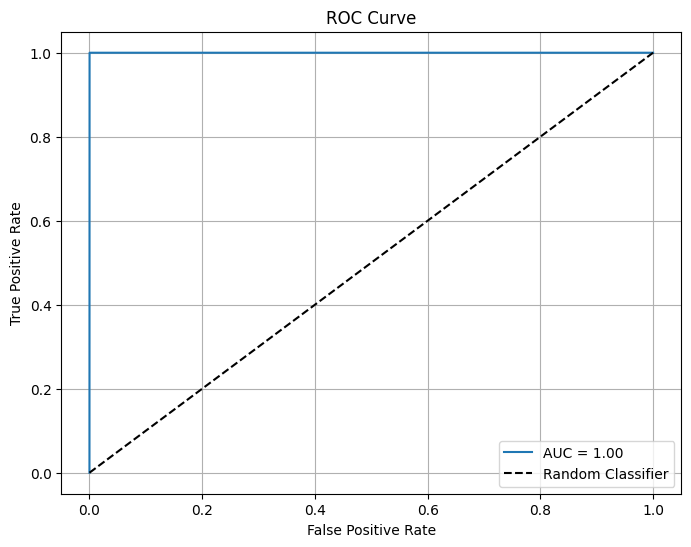

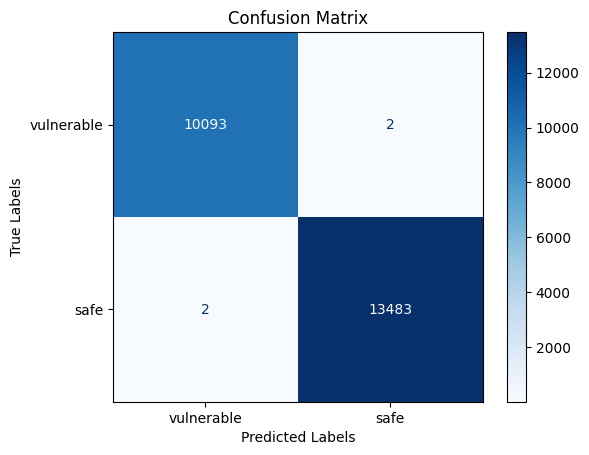

The Area Under Curve (AUC) is: 1.00


In [ ]:
auc = calculate_auc_roc(model, test_loader, device)
plot_confusion_matrix(model, test_loader, device)
print(f'The Area Under Curve (AUC) is: {auc:.2f}')

In [ ]:
adversarial_tokenized_dataset = load_from_disk(path+"Datasets/TransformedDataset/")

adversarial_train_dataset = adversarial_tokenized_dataset['train']
adversarial_val_dataset = adversarial_tokenized_dataset['validation']
adversarial_test_dataset = adversarial_tokenized_dataset['test']

batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
adversarial_train_loader = DataLoader(adversarial_train_dataset, batch_size=batch_size, shuffle=True)
adversarial_val_loader = DataLoader(adversarial_val_dataset, batch_size=batch_size, shuffle=True)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
adversarial_losses = test_model_adversarial(model, adversarial_test_loader, device, fp16=True)
adversarial_results = run_inference_and_collect_results_adversarial(model, adversarial_test_loader, device, fp16=True)

In [ ]:
print("Adversarial Losses:")
print(f"Original Loss: {adversarial_losses['original_loss']:.4f}")
print(f"Similar Characters Loss: {adversarial_losses['similar_loss']:.4f}")
print(f"Case Symbols Loss: {adversarial_losses['case_symbols_loss']:.4f}")
print(f"Unicode Replacement Loss: {adversarial_losses['unicode_loss']:.4f}\n")

# Evaluate metrics for each type
for key in adversarial_results:
    predictions = adversarial_results[key]["predictions"]
    labels = adversarial_results[key]["labels"]

    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print(f"Results for {key.capitalize()} Inputs:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("\n")

Adversarial Losses:
Original Loss: 0.0024
Similar Characters Loss: 0.0024
Case Symbols Loss: 0.0024
Unicode Replacement Loss: 0.0024

Results for Original Inputs:
  Accuracy: 99.98%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Similar Inputs:
  Accuracy: 99.98%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Case symbols Inputs:
  Accuracy: 99.98%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Unicode Inputs:
  Accuracy: 99.98%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


